<a href="https://colab.research.google.com/github/rahiakela/coursera-deep-learning-specialization/blob/course-4-convolutional-neural-networks/week_1_convolution_model_application_using_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks: Application

Welcome to Course 4's second assignment! In this notebook, you will:

- Implement helper functions that you will use when implementing a TensorFlow model
- Implement a fully functioning ConvNet using TensorFlow 

**After this assignment you will be able to:**

- Build and train a ConvNet in TensorFlow for a classification problem 

We assume here that you are already familiar with TensorFlow. If you are not, please refer the *TensorFlow Tutorial* of the third week of Course 2 ("*Improving deep neural networks*").

## 1.0 - TensorFlow model

In the previous assignment, you built helper functions using numpy to understand the mechanics behind convolutional neural networks. Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call. 

### Setup

As usual, we will start by loading in the packages. 

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

Run the next cell to load the "SIGNS" dataset you are going to use.

In [0]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

As a reminder, the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-specialization/signs.png?raw=1' width='800'/>

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

y = 0


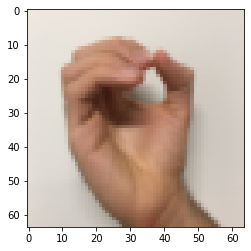

In [3]:
# Example of a picture
index = 1
plt.imshow(X_train_orig[index])
print(f'y = {str(np.squeeze(Y_train_orig[:, index]))}')

In Course 2, you had built a fully-connected network for this dataset. But since this is an image dataset, it is more natural to apply a ConvNet to it.

To get started, let's examine the shapes of your data. 

In [4]:
# scale the image's pixels data
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# convert to one-hot encoding
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print(f'number of training examples = {str(X_train_orig.shape[0])}')
print(f'number of test examples = {str(X_test_orig.shape[0])}')
print(f'X_train shape: {str(X_train.shape)}')
print(f'Y_train shape: {str(Y_train.shape)}')
print(f'X_test shape: {str(X_test.shape)}')
print(f'Y_test shape: {str(Y_test.shape)}')
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 1.1 - Create placeholders

TensorFlow requires that you create placeholders for the input data that will be fed into the model when running the session.

**Exercise**: Implement the function below to create placeholders for the input image X and the output Y. You should not define the number of training examples for the moment. To do so, you could use "None" as the batch size, it will give you the flexibility to choose it later. Hence X should be of dimension **[None, n_H0, n_W0, n_C0]** and Y should be of dimension **[None, n_y]**.  [Hint: search for the tf.placeholder documentation"](https://www.tensorflow.org/api_docs/python/tf/placeholder).

In [0]:
# FUNCTION: create_placeholders
def create_placeholders(n_H0, n_W0, n_C0, n_y):
  '''
  Creates the placeholders for the tensorflow session.
    
  Arguments:
  n_H0 -- scalar, height of an input image
  n_W0 -- scalar, width of an input image
  n_C0 -- scalar, number of channels of the input
  n_y -- scalar, number of classes
      
  Returns:
  X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
  Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
  '''

  ### START CODE HERE ### (≈2 lines)
  X = tf.placeholder(shape=(None, n_H0, n_W0, n_C0), dtype=tf.float32)
  Y = tf.placeholder(shape=(None, n_y), dtype=tf.float32)
  ### END CODE HERE ###
  
  return X, Y

In [6]:
X, Y = create_placeholders(64, 64, 3, 6)

print(f'X = {str(X)}')
print(f'Y = {str(Y)}')

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


**Expected Output**

<table> 
<tr>
<td>
    X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)

</td>
</tr>
<tr>
<td>
    Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)

</td>
</tr>
</table>

### 1.2 - Initialize parameters

You will initialize weights/filters $W1$ and $W2$ using `tf.contrib.layers.xavier_initializer(seed = 0)`. You don't need to worry about bias variables as you will soon see that TensorFlow functions take care of the bias. Note also that you will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically. We will talk more about that later in this assignment.

**Exercise:** Implement initialize_parameters(). The dimensions for each group of filters are provided below. Reminder - to initialize a parameter $W$ of shape [1,2,3,4] in Tensorflow, use:
```python
W = tf.get_variable("W", [1,2,3,4], initializer = ...)
```

#### tf.get_variable()

[Search for the tf.get_variable documentation](https://www.tensorflow.org/api_docs/python/tf/get_variable).  Notice that the documentation says:
```
Gets an existing variable with these parameters or create a new one.
```
So we can use this function to create a tensorflow variable with the specified name, but if the variables already exist, it will get the existing variable with that same name.

In [0]:
# FUNCTION: initialize_parameters
def initialize_parameters():
  '''
  Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                      W1 : [4, 4, 3, 8]
                      W2 : [2, 2, 8, 16]
  Note that we will hard code the shape values in the function to make the grading simpler.
  Normally, functions should take values as inputs rather than hard coding.
  Returns:
  parameters -- a dictionary of tensors containing W1, W2
  '''

  tf.set_random_seed(1)                  # so that your "random" numbers match ours

  ### START CODE HERE ### (approx. 2 lines of code)
  W1 = tf.get_variable('W1', [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  W2 = tf.get_variable('W2', [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
  ### END CODE HERE ###

  parameters = {'W1': W1, 'W2': W2}

  return parameters

In [8]:
tf.reset_default_graph()

with tf.Session() as sess_test:
  parameters = initialize_parameters()
  init = tf.global_variables_initializer()
  sess_test.run(init)

  print(f'W1[1,1,1] = \n {str(parameters["W1"].eval()[1,1,1])}')
  print(f'W1.shape: {str(parameters["W1"].shape)}')
  print('\n')

  print(f'W2[1,1,1] = \n {str(parameters["W2"].eval()[1,1,1])}')
  print(f'W2.shape: {str(parameters["W2"].shape)}')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1[1,1,1] = 
 [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W1.shape: (4, 4, 3, 8)


W2[1,1,1] = 
 [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
W2.shape: (2, 2, 8, 16)


** Expected Output:**

```
W1[1,1,1] = 
[ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W1.shape: (4, 4, 3, 8)


W2[1,1,1] = 
[-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]
W2.shape: (2, 2, 8, 16)
```

### 1.3 - Forward propagation

In TensorFlow, there are built-in functions that implement the convolution steps for you.

- **tf.nn.conv2d(X,W, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W$, this function convolves $W$'s filters on X. The third parameter ([1,s,s,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). Normally, you'll choose a stride of 1 for the number of examples (the first value) and for the channels (the fourth value), which is why we wrote the value as `[1,s,s,1]`. You can read the full documentation on [conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d).

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window.  For max pooling, we usually operate on a single example at a time and a single channel at a time.  So the first and fourth value in `[1,f,f,1]` are both 1.  You can read the full documentation on [max_pool](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool).

- **tf.nn.relu(Z):** computes the elementwise ReLU of Z (which can be any shape). You can read the full documentation on [relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu).

- **tf.contrib.layers.flatten(P)**: given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.  
    * If a tensor P has the shape (m,h,w,c), where m is the number of examples (the batch size), it returns a flattened tensor with shape (batch_size, k), where $k=h \times w \times c$.  "k" equals the product of all the dimension sizes other than the first dimension.
    * For example, given a tensor with dimensions [100,2,3,4], it flattens the tensor to be of shape [100, 24], where 24 = 2 * 3 * 4.  You can read the full documentation on [flatten](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten).

- **tf.contrib.layers.fully_connected(F, num_outputs):** given the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation on [full_connected](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected).

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters.

#### Window, kernel, filter

The words "window", "kernel", and "filter" are used to refer to the same thing.  This is why the parameter `ksize` refers to "kernel size", and we use `(f,f)` to refer to the filter size.  Both "kernel" and "filter" refer to the "window."

**Exercise**

Implement the `forward_propagation` function below to build the following model: 

`CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`. 

You should use the functions above. 

In detail, we will use the following parameters for all the steps:
 - Conv2D: stride 1, padding is "SAME"
 - ReLU
 - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - Conv2D: stride 1, padding is "SAME"
 - ReLU
 - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - Flatten the previous output.
 - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost.

In [0]:
# FUNCTION: forward_propagation
def forward_propagation(X, parameters):
  '''
  Implements the forward propagation for the model:
  CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
  
  Note that for simplicity and grading purposes, we'll hard-code some values
  such as the stride and kernel (filter) sizes. 
  Normally, functions should take these values as function parameters.
  
  Arguments:
  X -- input dataset placeholder, of shape (input size, number of examples)
  parameters -- python dictionary containing your parameters "W1", "W2"
                the shapes are given in initialize_parameters

  Returns:
  Z3 -- the output of the last LINEAR unit
  '''

  # Retrieve the parameters from the dictionary "parameters" 
  W1 = parameters['W1']
  W2 = parameters['W2']
  
  ### START CODE HERE ###
  # CONV2D: stride of 1, padding 'SAME'
  Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
  # RELU
  A1 = tf.nn.relu(Z1)
  # MAXPOOL: window 8x8, stride 8, padding 'SAME'
  P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')
  # CONV2D: filters W2, stride 1, padding 'SAME'
  Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
  # RELU
  A2 = tf.nn.relu(Z2)
  # MAXPOOL: window 4x4, stride 4, padding 'SAME'
  P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
  # FLATTEN
  F = tf.contrib.layers.flatten(P2)
  # FULLY-CONNECTED without non-linear activation function (not not call softmax).
  # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
  Z3 = tf.contrib.layers.fully_connected(F, 6, activation_fn=None)
  ### END CODE HERE ###

  return Z3

In [10]:
tf.reset_default_graph()

with tf.Session() as sess:
  np.random.seed(1)
  X, Y = create_placeholders(64, 64, 3, 6)
  parameters = initialize_parameters()
  Z3 = forward_propagation(X, parameters)
  init = tf.global_variables_initializer()
  sess.run(init)
  a = sess.run(Z3, {X: np.random.randn(2, 64, 64, 3), Y: np.random.randn(2, 6)})
  print(f'Z3 = \n {str(a)}')

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Z3 = 
 [[ 1.4416984  -0.24909686  5.4504986  -0.26189622 -0.20669895  1.3654672 ]
 [ 1.4070847  -0.02573191  5.08928    -0.486699   -0.40940708  1.2624857 ]]


**Expected Output**:

```
Z3 = 
[[-0.44670227 -1.57208765 -1.53049231 -2.31013036 -1.29104376  0.46852064]
 [-0.17601591 -1.57972014 -1.4737016  -2.61672091 -1.00810647  0.5747785 ]]
```

### 1.4 - Compute cost

Implement the compute cost function below. Remember that the cost function helps the neural network see how much the model's predictions differ from the correct labels.  By adjusting the weights of the network to reduce the cost, the neural network can improve its predictions.

You might find these two functions helpful: 

- **tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y):** computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss. You can check the full documentation  [softmax_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits).
- **tf.reduce_mean:** computes the mean of elements across dimensions of a tensor. Use this to calculate the sum of the losses over all the examples to get the overall cost. You can check the full documentation [reduce_mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean).

#### Details on softmax_cross_entropy_with_logits (optional reading)

* Softmax is used to format outputs so that they can be used for classification.  It assigns a value between 0 and 1 for each category, where the sum of all prediction values (across all possible categories) equals 1.
* Cross Entropy is compares the model's predicted classifications with the actual labels and results in a numerical value representing the "loss" of the model's predictions.
* "Logits" are the result of multiplying the weights and adding the biases.  Logits are passed through an activation function (such as a relu), and the result is called the "activation."
* The function is named `softmax_cross_entropy_with_logits` takes logits as input (and not activations); then uses the model to predict using softmax, and then compares the predictions with the true labels using cross entropy.  These are done with a single function to optimize the calculations.

**Exercise**: Compute the cost below using the function above.

In [0]:
# FUNCTION: compute_cost 
def compute_cost(Z3, Y):
  '''
  Computes the cost
    
  Arguments:
  Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
  Y -- "true" labels vector placeholder, same shape as Z3
  
  Returns:
  cost - Tensor of the cost function
  '''

  ### START CODE HERE ### (1 line of code)
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
  ### END CODE HERE ###

  return cost

In [12]:
tf.reset_default_graph()

with tf.Session() as sess:
  np.random.seed(1)
  X, Y = create_placeholders(64, 64, 3, 6)
  parameters = initialize_parameters()
  Z3 = forward_propagation(X, parameters)
  cost = compute_cost(Z3, Y)
  init = tf.global_variables_initializer()
  sess.run(init)
  a = sess.run(cost, {X: np.random.randn(4, 64, 64, 3), Y: np.random.randn(4, 6)})
  print(f'cost = {str(a)}')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = 4.6648703


**Expected Output**: 
```
cost = 2.91034
```

## 1.5 Model

Finally you will merge the helper functions you implemented above to build a model. You will train it on the SIGNS dataset. 

**Exercise**: Complete the function below. 

The model below should:

- create placeholders
- initialize parameters
- forward propagate
- compute the cost
- create an optimizer

Finally you will create a session and run a for loop  for num_epochs, get the mini-batches, and then for each mini-batch you will optimize the function. [Hint for initializing the variables](https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer)

#### Adam Optimizer

You can use `tf.train.AdamOptimizer(learning_rate = ...)` to create the optimizer.  The optimizer has a `minimize(loss=...)` function that you'll call to set the cost function that the optimizer will minimize.

For details, check out the documentation for [Adam Optimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

#### Random mini batches

If you took course 2 of the deep learning specialization, you implemented `random_mini_batches()` in the "Optimization" programming assignment. This function returns a list of mini-batches. It is already implemented in the `cnn_utils.py` file and imported here, so you can call it like this:
```Python
minibatches = random_mini_batches(X, Y, mini_batch_size = 64, seed = 0)
```
(You will want to choose the correct variable names when you use it in your code).

#### Evaluating the optimizer and cost

Within a loop, for each mini-batch, you'll use the `tf.Session` object (named `sess`) to feed a mini-batch of inputs and labels into the neural network and evaluate the tensors for the optimizer as well as the cost.  Remember that we built a graph data structure and need to feed it inputs and labels and use `sess.run()` in order to get values for the optimizer and cost.

You'll use this kind of syntax:
```
output_for_var1, output_for_var2 = sess.run(
                                                fetches=[var1, var2],
                                                feed_dict={var_inputs: the_batch_of_inputs,
                                                           var_labels: the_batch_of_labels}
                                                )
```
* Notice that `sess.run` takes its first argument `fetches` as a list of objects that you want it to evaluate (in this case, we want to evaluate the optimizer and the cost).  
* It also takes a dictionary for the `feed_dict` parameter.  
* The keys are the `tf.placeholder` variables that we created in the `create_placeholders` function above.  
* The values are the variables holding the actual numpy arrays for each mini-batch.  
* The sess.run outputs a tuple of the evaluated tensors, in the same order as the list given to `fetches`. 

For more information on how to use sess.run, see the documentation [tf.Sesssion#run](https://www.tensorflow.org/api_docs/python/tf/Session#run) documentation.

In [0]:
# FUNCTION: model
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009, num_epochs=100, minibatch_size=64, print_cost=True):
  '''
  Implements a three-layer ConvNet in Tensorflow:
  CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
  
  Arguments:
  X_train -- training set, of shape (None, 64, 64, 3)
  Y_train -- test set, of shape (None, n_y = 6)
  X_test -- training set, of shape (None, 64, 64, 3)
  Y_test -- test set, of shape (None, n_y = 6)
  learning_rate -- learning rate of the optimization
  num_epochs -- number of epochs of the optimization loop
  minibatch_size -- size of a minibatch
  print_cost -- True to print the cost every 100 epochs
  
  Returns:
  train_accuracy -- real number, accuracy on the train set (X_train)
  test_accuracy -- real number, testing accuracy on the test set (X_test)
  parameters -- parameters learnt by the model. They can then be used to predict.
  '''

  ops.reset_default_graph()                           # to be able to rerun the model without overwriting tf variables
  tf.set_random_seed(1)                               # to keep results consistent (tensorflow seed)
  seed = 3                                            # to keep results consistent (numpy seed)
  (m, n_H0, n_W0, n_C0) = X_train.shape
  n_y = Y_train.shape[1]
  costs = []                                          # To keep track of the cost

  # Create Placeholders of the correct shape
  ### START CODE HERE ### (1 line)
  X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
  ### END CODE HERE ###

  # Initialize parameters
  ### START CODE HERE ### (1 line)
  parameters = initialize_parameters()
  ### END CODE HERE ###

  # Forward propagation: Build the forward propagation in the tensorflow graph
  ### START CODE HERE ### (1 line)
  Z3 = forward_propagation(X, parameters)
  ### END CODE HERE ###

  # Cost function: Add cost function to tensorflow graph
  ### START CODE HERE ### (1 line)
  cost = compute_cost(Z3, Y)
  ### END CODE HERE ###

  # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
  ### START CODE HERE ### (1 line)
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
  ### END CODE HERE ###

  # Initialize all the variables globally
  init = tf.global_variables_initializer()

  # Start the session to compute the tensorflow graph
  with tf.Session() as sess:

    # Run the initialization
    sess.run(init)

    # Do the training loop
    for epoch in range(num_epochs):
      minibatch_cost = 0
      num_minibatches = int(m / minibatch_size)    # number of minibatches of size minibatch_size in the train set
      seed = seed + 1
      minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

      for minibatch in minibatches:
        # Select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        """
        # IMPORTANT: The line that runs the graph on a minibatch.
        # Run the session to execute the optimizer and the cost.
        # The feedict should contain a minibatch for (X,Y).
        """
        ### START CODE HERE ### (1 line)
        _ , temp_cost = sess.run(fetches=[optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
        ### END CODE HERE ###

        minibatch_cost += temp_cost / num_minibatches

      # Print the cost every epoch
      if print_cost == True and epoch % 5 == 0:
          print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
      if print_cost == True and epoch % 1 == 0:
          costs.append(minibatch_cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Calculate the correct predictions
    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    print(accuracy)
    train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
    test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
    print(f'Train Accuracy: {train_accuracy}')
    print(f'Test Accuracy: {test_accuracy}')

    return train_accuracy, test_accuracy, parameters, Y

Run the following cell to train your model for 100 epochs. Check if your cost after epoch 0 and 5 matches our output. If not, stop the cell and go back to your code!

Cost after epoch 0: 1.921332
Cost after epoch 5: 1.904156
Cost after epoch 10: 1.904309
Cost after epoch 15: 1.904477
Cost after epoch 20: 1.901876
Cost after epoch 25: 1.784094
Cost after epoch 30: 1.687816
Cost after epoch 35: 1.617915
Cost after epoch 40: 1.588564
Cost after epoch 45: 1.564675
Cost after epoch 50: 1.552992
Cost after epoch 55: 1.522002
Cost after epoch 60: 1.469448
Cost after epoch 65: 1.348304
Cost after epoch 70: 1.256776
Cost after epoch 75: 1.204447
Cost after epoch 80: 1.112992
Cost after epoch 85: 1.097759
Cost after epoch 90: 1.044009
Cost after epoch 95: 1.006472


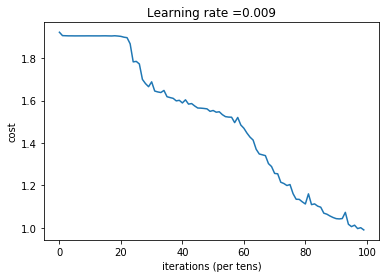

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.6722221970558167
Test Accuracy: 0.5249999761581421


In [14]:
_, _, parameters, Y = model(X_train, Y_train, X_test, Y_test)

**Expected output**: although it may not match perfectly, your expected output should be close to ours and your cost value should decrease.

<table> 
<tr>
    <td> 
    **Cost after epoch 0 =**
    </td>
    <td> 
      1.917929
    </td> 
</tr>
<tr>
    <td> 
    **Cost after epoch 5 =**
    </td>
    <td> 
      1.506757
    </td> 
</tr>
<tr>
    <td> 
    **Train Accuracy   =**
    </td>
    <td> 
      0.940741
    </td> 
</tr> 
<tr>
    <td> 
    **Test Accuracy   =**
    </td>
    <td> 
      0.783333
    </td> 
</tr> 
</table>

Congratulations! You have finished the assignment and built a model that recognizes SIGN language with almost 80% accuracy on the test set. If you wish, feel free to play around with this dataset further. You can actually improve its accuracy by spending more time tuning the hyperparameters, or using regularization (as this model clearly has a high variance). 

Once again, here's a thumbs up for your work! 

In [15]:
!pip install scipy==1.1.0  # install latest version for colab

In [17]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "thumbs_up.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = my_image
image = np.array(ndimage.imread(fname, flatten=False))
image = image/255.
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T

my_image_prediction = predict(my_image, parameters)
plt.imshow(my_image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


KeyError: ignored